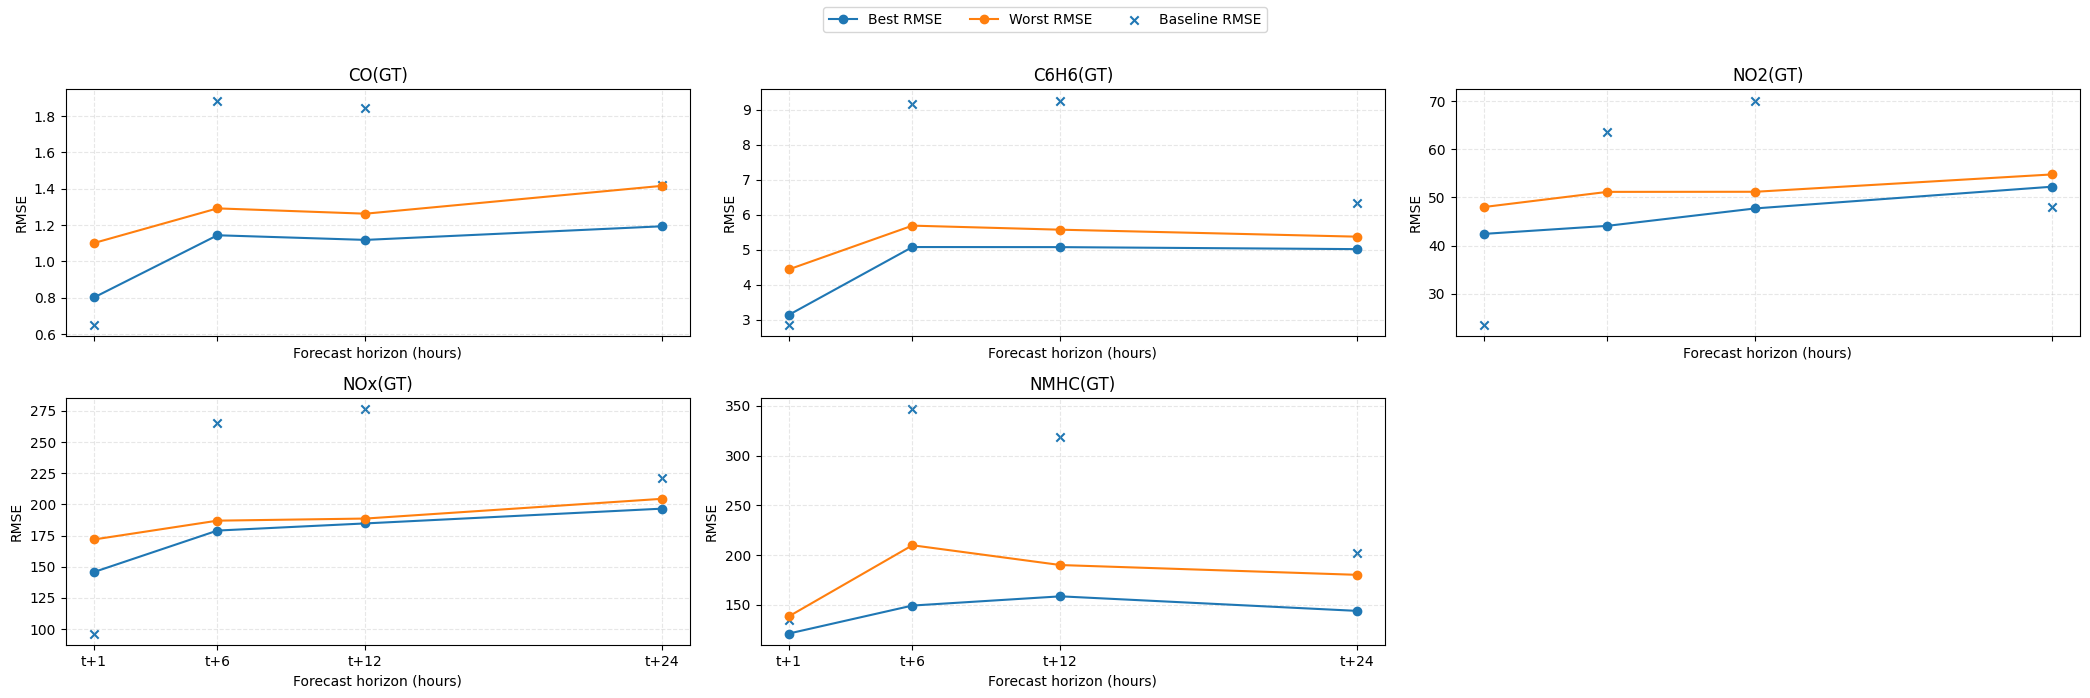

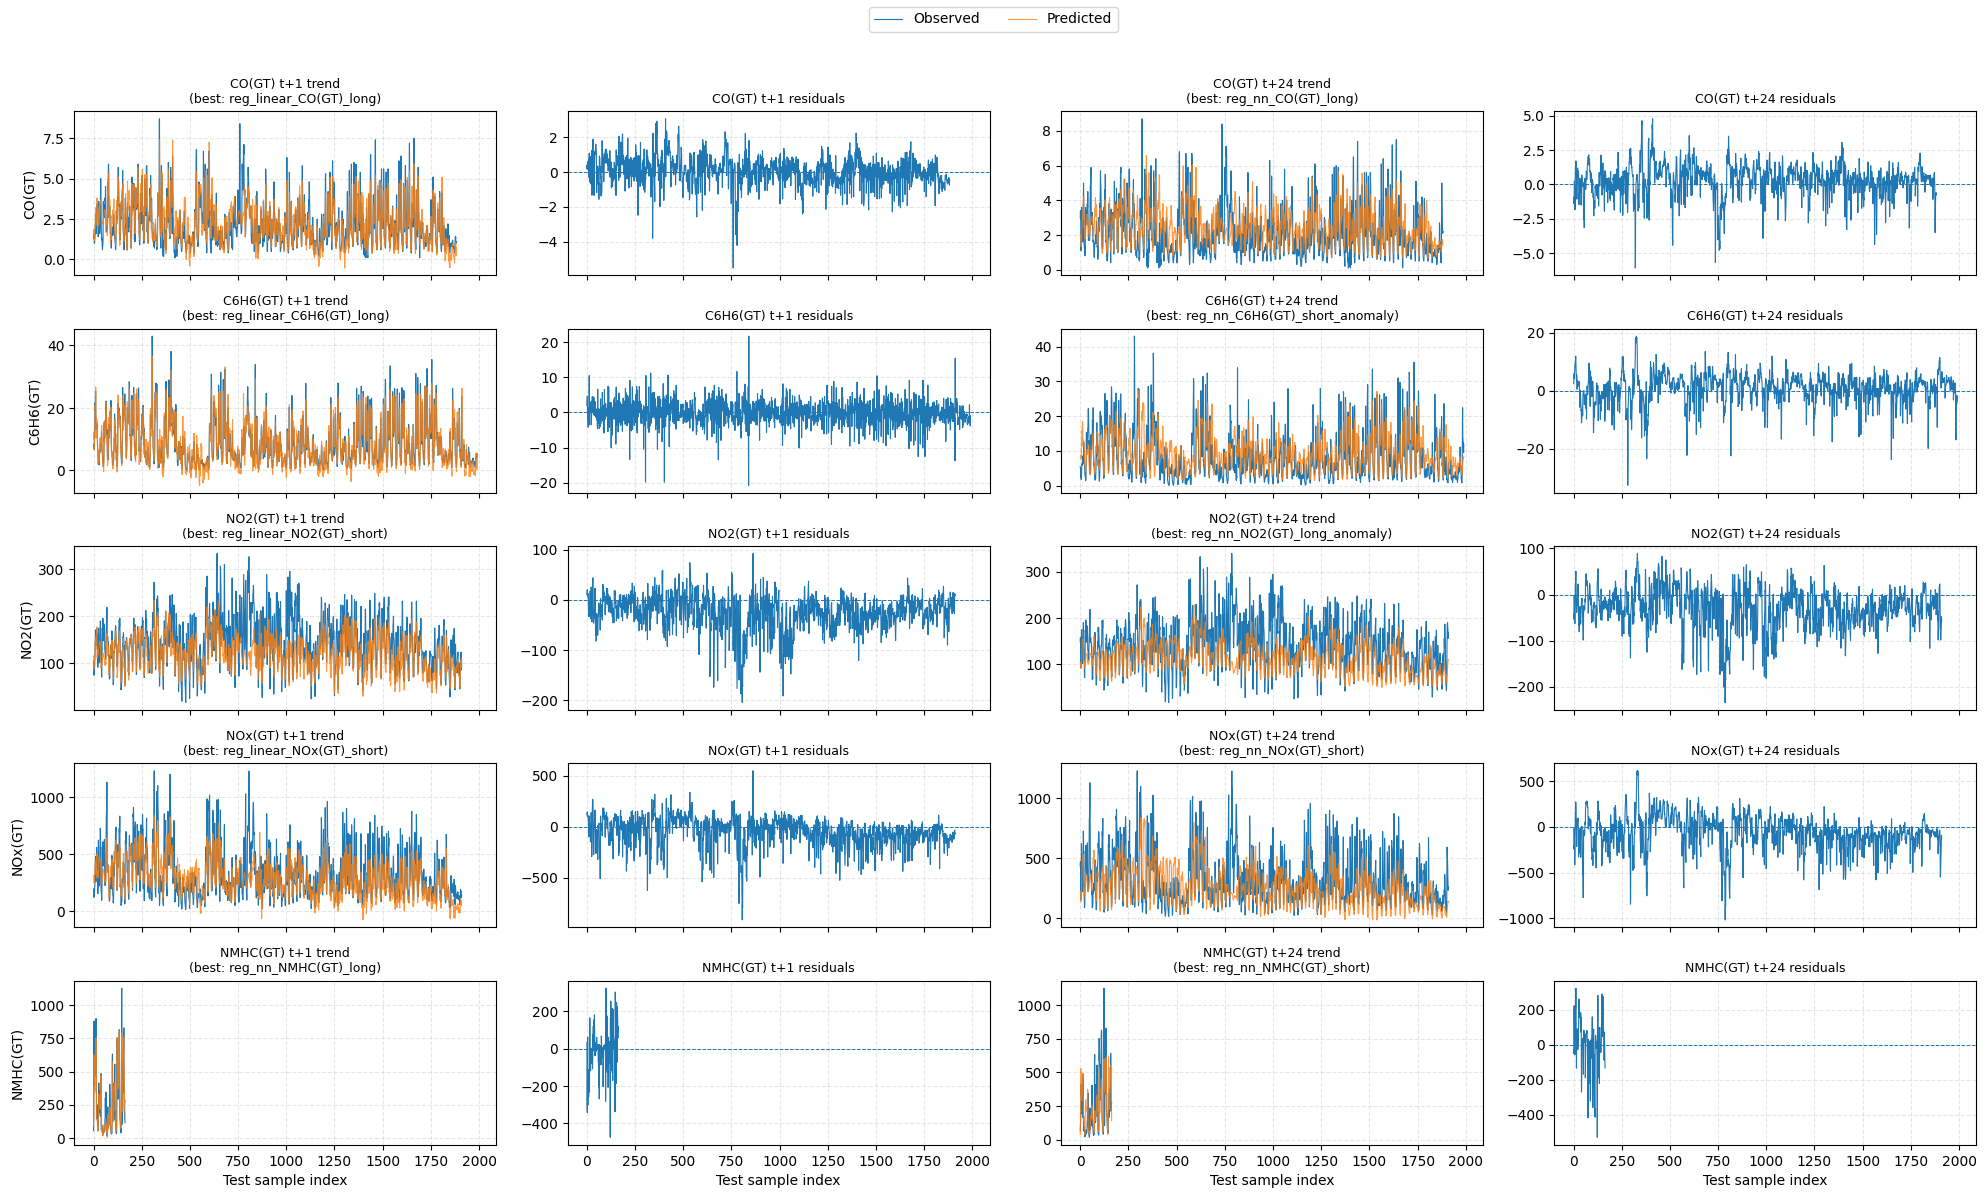

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt

#====================#
# 1. 读入 metrics_reg
#====================#
METRICS_REG_PATH = "metrics/metrics_reg.json"  # 根据需要修改路径

with open(METRICS_REG_PATH, "r") as f:
    metrics_reg = json.load(f)

# 所有污染物名称（从文件中自动抽取）
all_columns = sorted({m["column"] for m in metrics_reg.values()})

# 你想要的变量顺序（NMHC(GT) 最后）
col_order = ['CO(GT)', 'C6H6(GT)', 'NO2(GT)', 'NOx(GT)', 'NMHC(GT)']

# horizon 顺序（假定列顺序就是 [t+1, t+6, t+12, t+24]）
horizons = [1, 6, 12, 24]
horizon_labels = ["t+1", "t+6", "t+12", "t+24"]


#====================#
# 2. 一些辅助函数
#====================#
def per_horizon_rmse(y_pred, y_test):
    """对一个模型，计算 4 个 horizon 各自的 RMSE。"""
    y_pred = np.asarray(y_pred, float)
    y_test = np.asarray(y_test, float)
    assert y_pred.shape == y_test.shape
    diff = y_pred - y_test
    mse = np.mean(diff**2, axis=0)
    return np.sqrt(mse)


def get_best_key_for_column_and_horizon(metrics, col, h_index):
    """
    对于某污染物 col 和某个 horizon 索引 h_index（0 对应 t+1, 3 对应 t+24），
    找到 RMSE 最小的 (模型, 特征设置) 对应的 key。
    """
    best_key = None
    best_rmse = None
    for key, m in metrics.items():
        if m["column"] != col:
            continue
        rmse_h = per_horizon_rmse(m["Y_pred"], m["Y_test"])
        rmse_val = rmse_h[h_index]
        if best_rmse is None or rmse_val < best_rmse:
            best_rmse = rmse_val
            best_key = key
    return best_key, best_rmse


#========================================#
# 3. 利用 improvement 反推出 baseline RMSE
#    baseline_rmse[col][h] 为每列、每个 horizon 的 baseline RMSE
#========================================#
baseline_rmse = {col: None for col in all_columns}
baseline_accum = {col: [] for col in all_columns}

for key, m in metrics_reg.items():
    col = m["column"]
    rmse_h = per_horizon_rmse(m["Y_pred"], m["Y_test"])
    improv = np.asarray(m["improvement_over_baseline_percentage"], float)  # 长度 4

    # improvement 定义假设为:
    # improv% = (baseline_rmse_h - rmse_h) / baseline_rmse_h * 100
    # => baseline_rmse_h = rmse_h / (1 - improv/100)
    denom = 1.0 - improv / 100.0
    denom[np.isclose(denom, 0.0)] = np.nan  # 防止除零
    b = rmse_h / denom  # 这一模型估计出的 baseline RMSE
    baseline_accum[col].append(b)

for col in all_columns:
    arr = np.vstack(baseline_accum[col])  # (n_models_for_col, 4)
    baseline_rmse[col] = np.nanmean(arr, axis=0)  # 对不同模型求平均，更稳定


#========================================#
# 4. 为每个变量计算不同 horizon 上的 min/max RMSE（跨所有模型）
#========================================#
min_rmse = {col: None for col in all_columns}
max_rmse = {col: None for col in all_columns}

for col in all_columns:
    rmse_list = []
    for key, m in metrics_reg.items():
        if m["column"] != col:
            continue
        rmse_h = per_horizon_rmse(m["Y_pred"], m["Y_test"])
        rmse_list.append(rmse_h)
    rmse_arr = np.vstack(rmse_list)  # shape: (n_models_for_col, 4)
    min_rmse[col] = rmse_arr.min(axis=0)
    max_rmse[col] = rmse_arr.max(axis=0)


#========================================#
# 5. 图 1：每个变量一幅子图的 RMSE vs horizon 图
#   - 3×2 布局，NMHC(GT) 在最后一个子图
#   - 两条折线：min / max RMSE
#   - baseline RMSE 用散点标注
#========================================#
fig, axes = plt.subplots(2, 3, figsize=(21, 7), sharex=True)
axes = axes.flatten()

for idx, col in enumerate(col_order):
    ax = axes[idx]
    ax.plot(horizons, min_rmse[col], marker='o', label='Best RMSE')
    ax.plot(horizons, max_rmse[col], marker='o', label='Worst RMSE')
    ax.scatter(horizons, baseline_rmse[col], marker='x', label='Baseline RMSE')

    ax.set_title(col)
    ax.set_xlabel("Forecast horizon (hours)")
    ax.set_ylabel("RMSE")
    ax.set_xticks(horizons)
    ax.set_xticklabels(horizon_labels)
    ax.grid(True, linestyle='--', alpha=0.3)

# 如果只用了 5 个变量，删除第 6 个空子图
if len(col_order) < len(axes):
    for j in range(len(col_order), len(axes)):
        fig.delaxes(axes[j])

# 统一图例
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
fig.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()


#========================================#
# 6. 图 2：5×4 布局，trends + residuals
#   每一行对应一个变量：
#   [col t+1 trend, col t+1 residual, col t+24 trend, col t+24 residual]
#========================================#
n_rows = len(col_order)
fig2, axes2 = plt.subplots(n_rows, 4, figsize=(20, 12), sharex='col')

for row, col in enumerate(col_order):
    # 对 t+1 (h_index=0) 和 t+24 (h_index=3) 各找一个最优模型
    for h_index, col_offset in [(0, 0), (3, 2)]:
        best_key, best_rmse_val = get_best_key_for_column_and_horizon(
            metrics_reg, col, h_index
        )
        m = metrics_reg[best_key]
        y_pred = np.asarray(m["Y_pred"], float)[:, h_index]
        y_test = np.asarray(m["Y_test"], float)[:, h_index]
        x = np.arange(len(y_test))  # 用样本索引作为“时间”

        h_label = "t+1" if h_index == 0 else "t+24"

        # ------- trend 子图 -------
        trend_ax = axes2[row, col_offset]
        trend_ax.plot(x, y_test, label="Observed", linewidth=0.8)
        trend_ax.plot(x, y_pred, label="Predicted", linewidth=0.8, alpha=0.8)
        trend_ax.set_title(f"{col} {h_label} trend\n(best: {best_key})", fontsize=9)
        if row == n_rows - 1:
            trend_ax.set_xlabel("Test sample index")
        if col_offset == 0:
            trend_ax.set_ylabel(col)
        trend_ax.grid(True, linestyle='--', alpha=0.3)

        # ------- residual 子图 -------
        resid_ax = axes2[row, col_offset + 1]
        resid = y_pred - y_test
        resid_ax.plot(x, resid, linewidth=0.8)
        resid_ax.axhline(0.0, linestyle="--", linewidth=0.7)
        resid_ax.set_title(f"{col} {h_label} residuals", fontsize=9)
        if row == n_rows - 1:
            resid_ax.set_xlabel("Test sample index")
        resid_ax.grid(True, linestyle='--', alpha=0.3)

# 统一 trend 图例（Observed / Predicted）
handles2, labels2 = axes2[0, 0].get_legend_handles_labels()
fig2.legend(handles2, labels2, loc='upper center', ncol=2)

fig2.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
